In [1]:
import random
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as opt
import pomegranate as pm
from tqdm import tqdm

from itertools import combinations

graph.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'pomegranate'

# Vectors and Matrices

In [2]:
# vector
v = np.array([0, 1, 2, 3])
v.shape

(4,)

In [3]:
# matrix
m = v.reshape((4, 1))
m.shape

(4, 1)

In [4]:
m

array([[0],
       [1],
       [2],
       [3]])

In [5]:
m.T

array([[0, 1, 2, 3]])

In [6]:
x = stats.norm.rvs(100, 15, size=750)
print(x.shape)

(750,)


In [7]:
# average
(1/len(x))*sum(x)

99.93539748196899

In [8]:
x = np.array([0.25, 0.33, 0.5])
print(x.shape)
print(x)

(3,)
[0.25 0.33 0.5 ]


# Probability

In [9]:
p = x.prod()
print(p)

0.04125


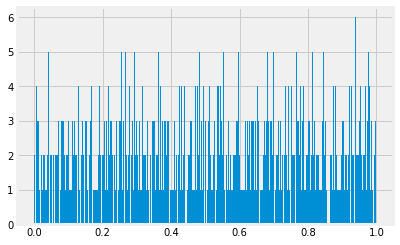

In [10]:
x = stats.uniform.rvs(0, 1, size=1000)
graph.hist(x, bins=500)
graph.show()

In [11]:
x.prod()

0.0

In [12]:
np.log(x).sum()

-964.7249732691465

In [13]:
# Likelihood
print(stats.norm.pdf(100, 100, 15) / stats.norm.pdf(125, 100, 15))

iq_us = np.array([155, 140, 125])

a = stats.norm(100, 15).pdf(iq_us).prod()
b = stats.norm(100, 15).pdf(3*[100]).prod()
print(b/a)

4.010391585875743
116618.90399762249


# Model making

$$ y = mx + b $$

$$ y = \mathcal{N}(mx + b , \sigma) $$

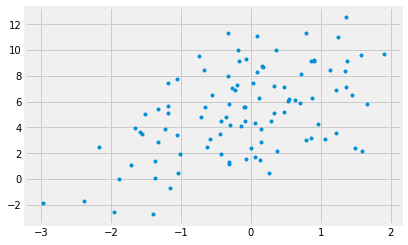

In [14]:
m, b = 2, 5
s = 3
n = 100

x = stats.norm.rvs(size=n)
y = (m * x) + b + stats.norm(0, s).rvs(size=n)

graph.plot(x, y, '.')
graph.show()

In [15]:
def log_likelihood(slope, intercept, noise):
    y_guess = slope*x + intercept
    residual = y - y_guess
    return stats.norm(0, np.abs(noise)).logpdf(residual).sum()

In [16]:
def likelihood(slope, intercept, noise):
    y_guess = slope*x + intercept
    residual = y - y_guess
    return stats.norm(0, np.abs(noise)).pdf(residual).prod()

-382.98534049766926 -282.6128166988991


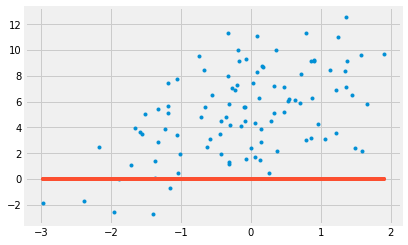

In [17]:
print(log_likelihood(0, 0, y.std()), log_likelihood(2, 5, 6))

graph.plot(x, y, '.')
graph.plot(x, np.zeros(y.shape))
graph.show()

In [18]:
path = []
def log_like_wrapper(guess):
    score = -log_likelihood(*guess)
    path.append(score)
    return score

print(log_like_wrapper([0, 0, y.std()]))

382.98534049766926


In [19]:
path = []
def like_wrapper(guess):
    score = -likelihood(*guess)
    path.append(score)
    return score

print(like_wrapper([0, 0, y.std()]))

-4.694398701388085e-167


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 205
         Function evaluations: 365


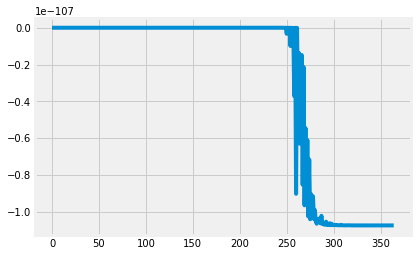

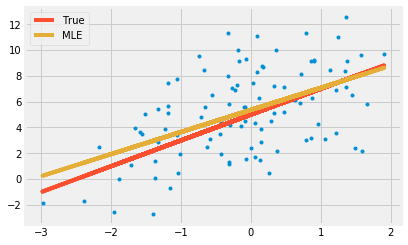

[1.71150343 5.36206557 2.84081012]


In [20]:
path = []
params = opt.fmin(like_wrapper, [0, 0, y.std()], disp=True)

graph.plot(path)
graph.show()

graph.plot(x, y, '.')
graph.plot(x, (m*x)+ b, label='True')
graph.plot(x, params[0]*x + params[1], label='MLE')
graph.legend()
graph.show()

print(params)

Optimization terminated successfully.
         Current function value: 246.303759
         Iterations: 205
         Function evaluations: 365


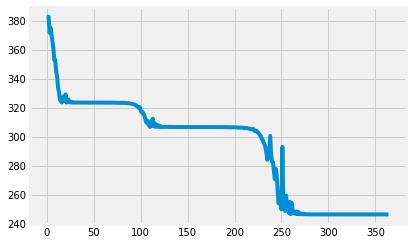

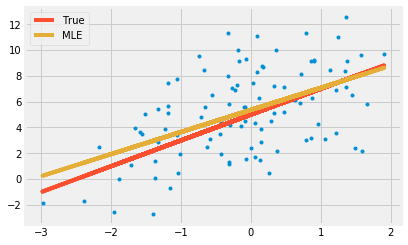

[1.71150343 5.36206557 2.84081012]


In [21]:
path = []
params = opt.fmin(log_like_wrapper, [0, 0, y.std()], disp=True)

graph.plot(path)
graph.show()

graph.plot(x, y, '.')
graph.plot(x, (m*x)+ b, label='True')
graph.plot(x, params[0]*x + params[1], label='MLE')
graph.legend()
graph.show()

print(params)

# Bayesian Modelling

In [29]:
iterations = 500
progressor = tqdm(range(iterations))

current = np.array([0, 0, 100])
step_size = 0.1

trace = []
for i in progressor:
    # Get current likelihood
    current_loglike = -log_likelihood(*current)
    
    # Get potential likelihood
    next_step = current + stats.norm(0, step_size).rvs(size=current.shape)
    potential_loglike = -log_likelihood(*next_step)
    
    # Compute probability of accepting the new step
    odds = np.e ** (potential_loglike - current_loglike)
    odds = np.clip(odds, 1e-6, 1e6)
    
    # Accept potential at the odds of stepping there
    current = random.choices([current, next_step], weights=[1, odds])[0]
    
    progressor.set_description(f'{current_loglike:0.3f} = L({current}|y)')
    trace.append(current)
    
# results
trace = np.vstack(trace)
print(trace.shape)

555.644 = L([ -1.10263359   1.45374497 103.13582518]|y): 100%|██████████| 500/500 [00:02<00:00, 216.82it/s]         


(500, 3)


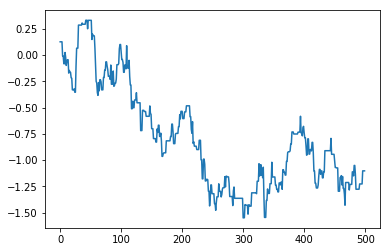

In [30]:
graph.plot(trace[:, 0])
graph.show()

In [32]:
# Bayesian with likelihood, not loglikelihood

iterations = 500
progressor = tqdm(range(iterations))

current = np.array([0, 0, 1])
step_size = 0.1

trace = []
for i in progressor:
    # Get currently likelihood
    current_like = -likelihood(*current)
    
    # Get potential likelihood
    next_step = current + stats.norm(0, step_size).rvs(size=current.shape)
    potential_like = -likelihood(*next_step)
    
    # Compute probability of accepting the new step
    odds = potential_like - current_like
    odds = np.clip(odds, 1e-6, 1e6)
    
    # Accept potential at the odds of stepping there
    current = random.choices([current, next_step], weights=[1, odds])[0]
    
    progressor.set_description(f'{current_like:0.3f} = L({current}|y)')
    trace.append(current)
    
# results
trace = np.vstack(trace)
print(trace.shape)

-0.000 = L([0 0 1]|y): 100%|██████████| 500/500 [00:02<00:00, 209.82it/s]


(500, 3)


## DFE-Alpha

In [35]:
def delta_q(s, q):
    assert s <= 1
    return (-s*q*(1-q) / 2*(1-s*q))

In [36]:
def m(n, k, q, s):
    def delta_q(s, q):
        assert s <= 1
        return (-s*q*(1-q) / 2*(1-s*q))


In [37]:
s_range = np.random.gamma(1, scale=0.5, size=int(1e6))

/home/arshad/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


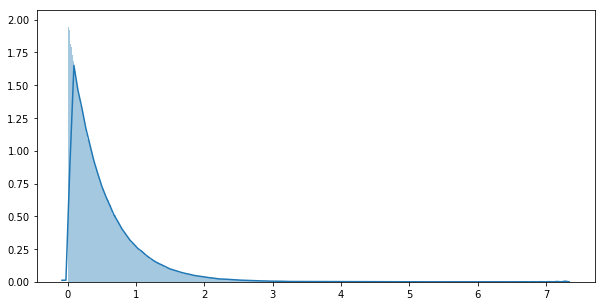

In [38]:
graph.figure(figsize=(10, 5))
sns.distplot(s_range, bins=1000)
graph.show()

In [39]:
print(f'{sum(i > 1 for i in s_range) / len(s_range) * 100} % above 1')

13.570699999999999 % above 1
